# MATLAB 파일을 머신 러닝으로 변환하기 CSV 파일 읽기
- 이 데이터 집합의 새 버전이 게시되었습니다.
- 이 데이터 세트는 원본 원시 데이터 세트를 탐색하여 훨씬 더 나은 형식의 머신 러닝 지원 데이터 세트로 변환합니다.

In [1]:
# Some boring imports
import numpy as np
import pandas as pd
import os
import scipy.io

In [2]:
# Helper functions
def load_filelist():
    
    FILELIST = []
    for dirname, _, filenames in os.walk('/kaggle/input'):
        for filename in filenames:

            #filepath = filename
            FILELIST.append(os.path.join(dirname, filename))
    return FILELIST
            
            
def filter_matfiles_list(filelist):
    filelist = [filepath for filepath in filelist if filepath.endswith('.mat')]
    filelist = [filepath for filepath in filelist if "BatteryAgingARC_25_26_27_28_P1" not in filepath] # removing duplicates
    return filelist


def loadmat(filepath):
    return scipy.io.loadmat(filepath, simplify_cells=True)

In [3]:
FILELIST = filter_matfiles_list(load_filelist())

## 일반 데이터 세트 정보
충전 및 방전 주기가 반복되면 배터리 노화가 가속화되며, 임피던스 측정은 노화가 진행됨에 따라 변화하는 배터리 내부 매개 변수에 대한 통찰력을 제공합니다.

- 충전 프로필:
    - 모든 배터리 테스트의 충전 프로필은 동일한 것으로 보입니다.
    - 충전은 배터리 전압이 4.2V에 도달할 때까지 1.5A의 정전류(CC) 모드에서 수행한 다음 충전 전류가 20mA로 떨어질 때까지 정전압(CV) 모드에서 계속 진행했습니다. 

- 방전:
    - 방전 프로필은 배터리마다 달랐습니다.
    - 방전은 배터리 전압이 2.7V, 2.5V, 2.2V, 2.5V 등의 값으로 떨어질 때까지 1~4A의 정전류(CC) 수준에서 수행되었습니다.

- 임피던스:
    - 임피던스 측정은 0.1Hz ~ 5kHz의 전기 화학 임피던스 분광법(EIS) 주파수 스윕을 통해 수행되었습니다.

배터리가 지정된 수명 종료(EOL) 기준(예: 정격 용량이 30% 감소(2Ahr에서 1.4Ahr로))에 도달하면 실험을 중단했습니다. 정격 용량 20% 감소와 같은 다른 중단 기준도 사용되었습니다. 배터리 49,50,51,52의 경우 배터리 EOL로 인해 실험이 중지된 것이 아니라 소프트웨어가 충돌했기 때문에 실험이 중지되었습니다.

# 작업

이 데이터 세트는 다음 두 가지를 예측하는 데 사용할 수 있습니다:
- 남은 충전량(주어진 방전 주기에 대한) 및,
- 남은 유효 수명(RUL).


## .mat 파일의 구조
- **사전** (로드된 mat 파일)
    - **사전** (예: B0005)
        - **목록(사이클)** -> 목록의 요소당 하나의 테스트
            - 목록의 요소 = 딕셔너리 = 해당 배터리의 한 테스트에 대한 모든 데이터
                - **유형**: 작동 유형, 충전, 방전 또는 임피던스가 될 수 있습니다.
                - **주변 온도**: 주변 온도(섭씨)
                - **시간**: 사이클 시작 날짜 및 시간, MATLAB 날짜 벡터 형식
                - **데이터(딕셔너리)**: 측정값을 포함하는 데이터 구조
                    - 키가 측정 변수인 데이터 필드, 실제 레코드 값(아래 참조)
                    
                    
* 충전의 경우 필드는 다음과 같습니다:
    * 전압_측정: 	배터리 단자 전압(볼트)
    * 전류_측정:	배터리 출력 전류(암페어)
    * 온도_측정: 	배터리 온도(섭씨)
    * Current_charge:		충전기에서 측정된 전류(암페어)
    * 전압_충전:		충전기에서 측정된 전압(볼트)
    * 시간: 사이클의 시간 벡터(초)
* 방전의 경우 필드는 다음과 같습니다:
    * 전압_측정: 	배터리 단자 전압(볼트)
    * 전류_측정:	배터리 출력 전류(암페어)
    * 온도_측정: 	배터리 온도(섭씨)
    * Current_load:		부하에서 측정된 전류(암페어)
    * 전압_부하:		부하에서 측정된 전압(볼트)
    * 시간: 사이클의 시간 벡터(초)
    * 용량:		2.7V까지 방전 시 배터리 용량(Ahr) 
* 임피던스의 경우 필드입니다:
    * Sense_current:		감지 분기의 전류(암페어)
    * 배터리_전류:	배터리 분기의 전류(암페어)
    * 전류_비율:		위 전류의 비율 
    * 배터리_임피던스:	원시 데이터에서 계산된 배터리 임피던스(옴)
    * 정류된_임피던스:	보정 및 평활화된 배터리 임피던스(옴) 
    * Re:			예상 전해질 저항(옴)
    * Rct:			예상 전하 전달 저항(옴)

### README 파일의 차이점
- 방전 CC 레벨
- 방전 실행 정지 전압
- EOL 기준(30% -> 1.4Ah, 20% -> 1.6Ah, 소프트웨어 충돌)

# TODOs
- README 파일의 정보를 포함하도록 새 열로 메타데이터를 채우세요...
- start_time

**README**
- 

In [4]:
mat = loadmat("./nasa_mat/B0005.mat")

In [5]:
df = pd.DataFrame(data=mat['B0005']['cycle'][0]['data'])

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 789 entries, 0 to 788
Data columns (total 6 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   Voltage_measured      789 non-null    float64
 1   Current_measured      789 non-null    float64
 2   Temperature_measured  789 non-null    float64
 3   Current_charge        789 non-null    float64
 4   Voltage_charge        789 non-null    float64
 5   Time                  789 non-null    float64
dtypes: float64(6)
memory usage: 37.1 KB


In [7]:
import matplotlib.pyplot as plt

def plot_test_data(df, profile="charge"):
    
    if profile=='charge':
        plt.figure(figsize=(10,4))
        plt.plot(df.Time, df.Voltage_measured, 'b', label='Voltage_measured')
        plt.plot(df.Time, df.Current_measured, 'r', label='Current_measured')
        plt.legend()
        plt.show()

        plt.figure(figsize=(10,4))
        plt.plot(df.Time, df.Voltage_charge, 'b', label='Voltage_charge')
        plt.plot(df.Time, df.Current_charge, 'r', label='Current_charge')
        plt.legend()
        plt.show()

        plt.figure(figsize=(10,4))
        plt.plot(df.Time, df.Temperature_measured, 'k', label='Temperature_measured')
        plt.legend()
        plt.show()
    elif profile=='discharge':
        plt.figure(figsize=(10,4))
        plt.plot(df.Time, df.Voltage_measured, 'b', label='Voltage_measured')
        plt.plot(df.Time, df.Current_measured, 'r', label='Current_measured')
        plt.legend()
        plt.show()

        plt.figure(figsize=(10,4))
        plt.plot(df.Time, df.Voltage_load, 'b', label='Voltage_load')
        plt.plot(df.Time, df.Current_load, 'r', label='Current_load')
        plt.legend()
        plt.show()

        plt.figure(figsize=(10,4))
        plt.plot(df.Time, df.Temperature_measured, 'k', label='Temperature_measured')
        plt.legend()
        plt.show()
    elif profile=='impedance':
        pass
    else:
        print('No cycle recognized')

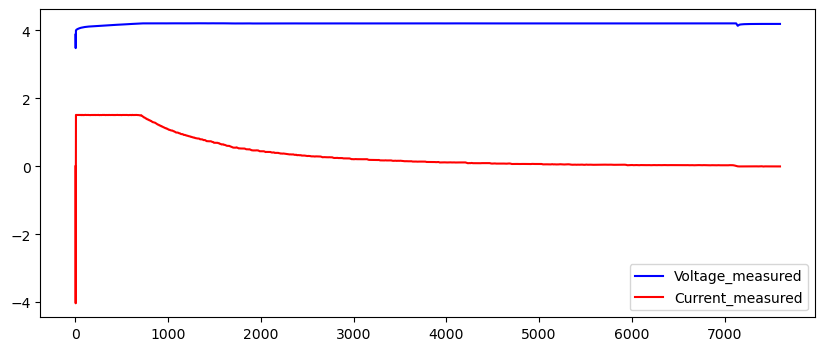

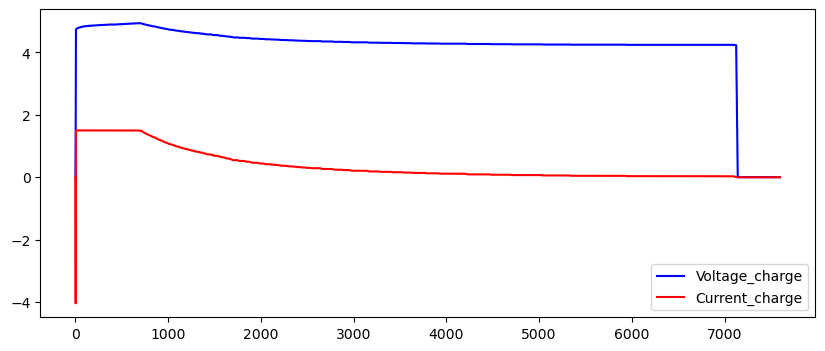

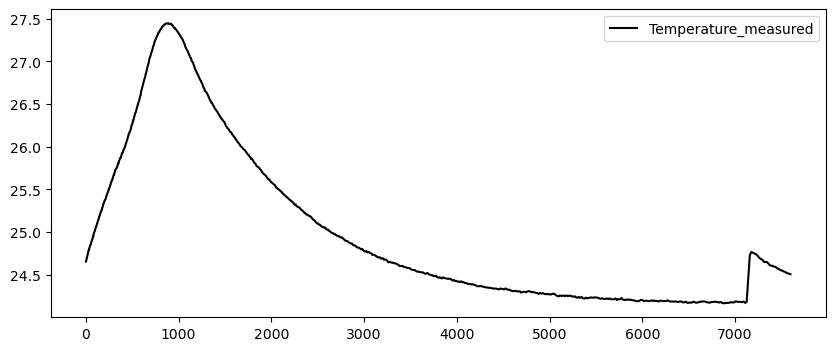

In [8]:
plot_test_data(df)

In [9]:
df = pd.DataFrame(data=mat['B0005']['cycle'][1]['data'])
df.head()

,Voltage_measured,Current_measured,Temperature_measured,Current_load,Voltage_load,Time,Capacity
0,4.191492,-0.004902,24.330034,-0.0006,0.000,0.000,1.856487
1,4.190749,-0.001478,24.325993,-0.0006,4.206,16.781,1.856487
2,3.974871,-2.012528,24.389085,-1.9982,3.062,35.703,1.856487
3,3.951717,-2.013979,24.544752,-1.9982,3.030,53.781,1.856487
4,3.934352,-2.011144,24.731385,-1.9982,3.011,71.922,1.856487


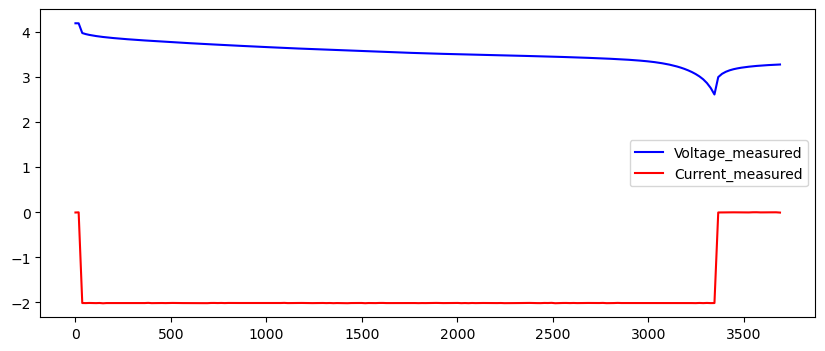

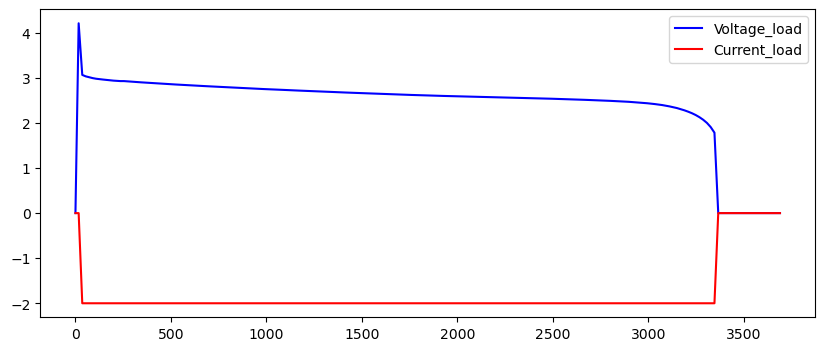

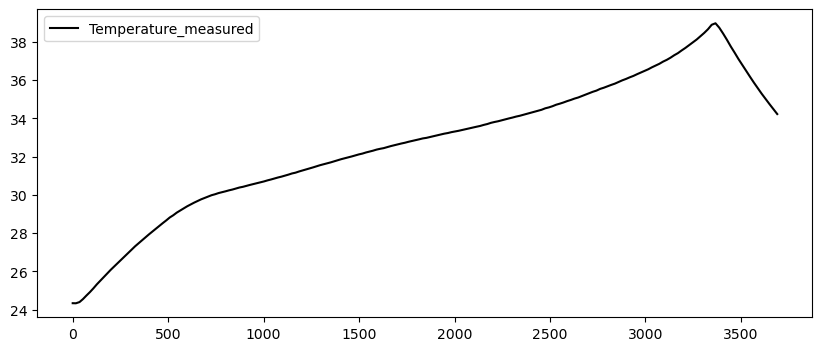

In [10]:
plot_test_data(df, profile='discharge')

In [11]:
def process_data_dict(data_dict):
    """ Creates two dictionaries:
    - ndict: new dictionary with the test data to build a corresponding dataframe
    - metadata_dict: anything that doesn't fit in ndict ('Capacity' is just a float)
    """
    
    ndict = {}
    metadata_dict = {}
    for k, v in data_dict.items():
        if k not in ['Capacity', 'Re', 'Rct']:
            ndict[k]=v
        elif k == 'Capacity':
            metadata_dict[k]=v
        elif k == 'Re':
            metadata_dict[k]=v
        elif k == 'Rct':
            metadata_dict[k]=v
        else:
            print("c'est la merde")
    
    return ndict, metadata_dict


def fill_metadata_row(metadata, test_type, test_start_time, test_temperature, battery_name, test_id, uid, filename, capacity, re, rct):
    tmp = pd.DataFrame(data=[test_type, test_start_time, test_temperature, battery_name, test_id, uid, filename, capacity, re, rct])
    tmp = tmp.transpose()
    tmp.columns = metadata.columns
    metadata = pd.concat((metadata, tmp), axis=0)
    return metadata


def extract_more_metadata(metadata_dict):
    
    if 'Capacity' in metadata_dict.keys():
        capacity = metadata_dict['Capacity']
    else:
        capacity = np.nan
        
    if 'Re' in metadata_dict.keys():
        re = metadata_dict['Re']
    else:
        re = np.nan
        
    if 'Rct' in metadata_dict.keys():
        rct = metadata_dict['Rct']
    else:
        rct = np.nan
    
    return capacity, re, rct

In [12]:
metadata = pd.DataFrame(data=None, columns=['type', 'start_time', 'ambient_temperature', 'battery_id', 'test_id', 'uid', 'filename', 'Capacity', 'Re', 'Rct'])
battery_list = [item.split('/')[-1].split('.')[0] for item in FILELIST]

In [13]:
# We create a tmp directory in which we will save all CSV files
CWD = os.getcwd()
os.listdir(CWD)
directory = "tmp"
path = os.path.join(CWD, directory)
if not os.path.exists(path):
    os.mkdir(path)

In [14]:
os.listdir(CWD) # we check that tmp exists now

['.ipynb_checkpoints',
 'nasa-dataset-cleaning.ipynb',
 'nasa_csv',
 'nasa_mat',
 'pre_data.ipynb',
 'tmp']

In [15]:
uid = 0
# counter = 0
for battery_name, mat_filepath in zip(battery_list, FILELIST):
    # counter +=1
    
    mat_data = scipy.io.loadmat(mat_filepath, simplify_cells=True)
    print(mat_filepath[-10:],"-->", battery_name)
    test_list = mat_data[battery_name]['cycle']
    
    for test_id in range(len(test_list)):
        
        uid += 1
        filename = str(uid).zfill(5)+'.csv'
        filepath = './tmp/' + filename

        # Extract the specific test data and save it as CSV! 
        ndict, metadata_dict = process_data_dict(test_list[test_id]['data'])
        test_df = pd.DataFrame.from_dict(ndict, orient='index')
        test_df = test_df.transpose()

        test_df.to_csv(filepath, index=False)
                
        # Add test information to the metadata
        test_type = test_list[test_id]['type']
        test_start_time = test_list[test_id]['time']
        test_temperature = test_list[test_id]['ambient_temperature']
        
        capacity, re, rct = extract_more_metadata(metadata_dict)
        metadata = fill_metadata_row(metadata, test_type, test_start_time, test_temperature, battery_name, test_id, uid, filename, capacity, re, rct)
        
    # if counter > 2:
    #    break

/B0047.mat --> B0047
/B0045.mat --> B0045
/B0048.mat --> B0048
/B0046.mat --> B0046
/B0043.mat --> B0043
/B0032.mat --> B0032
/B0039.mat --> B0039
/B0040.mat --> B0040
/B0029.mat --> B0029
/B0028.mat --> B0028
/B0042.mat --> B0042
/B0034.mat --> B0034
/B0038.mat --> B0038
/B0033.mat --> B0033
/B0030.mat --> B0030
/B0041.mat --> B0041
/B0027.mat --> B0027
/B0044.mat --> B0044
/B0036.mat --> B0036
/B0025.mat --> B0025
/B0026.mat --> B0026
/B0031.mat --> B0031
/B0049.mat --> B0049
/B0050.mat --> B0050
/B0052.mat --> B0052
/B0051.mat --> B0051
/B0006.mat --> B0006
/B0005.mat --> B0005
/B0007.mat --> B0007
/B0018.mat --> B0018
/B0053.mat --> B0053
/B0054.mat --> B0054
/B0056.mat --> B0056
/B0055.mat --> B0055


In [16]:
metadata.to_csv('metadata.csv', index=False)

In [17]:
metadata.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7565 entries, 0 to 0
Data columns (total 10 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   type                 7565 non-null   object
 1   start_time           7565 non-null   object
 2   ambient_temperature  7565 non-null   object
 3   battery_id           7565 non-null   object
 4   test_id              7565 non-null   object
 5   uid                  7565 non-null   object
 6   filename             7565 non-null   object
 7   Capacity             2794 non-null   object
 8   Re                   1956 non-null   object
 9   Rct                  1956 non-null   object
dtypes: object(10)
memory usage: 650.1+ KB


In [18]:
import shutil

In [19]:
shutil.make_archive('data', 'zip', 'tmp')

'/kaggle/working/data.zip'

## 문제  
배터리 25,26,27,28에 몇 개의 중복이 있는 것 같습니다. 실제로 데이터를 확인해 봅시다.
- 원시 데이터를 보면 중복이 있음을 확인할 수 있습니다.